# Installing Necessary Dependencies

In [1]:
!pip install transformers datasets

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.8 MB/s eta 0:00:00


# Loading Necessary Libraries

In [2]:
from transformers import AutoTokenizer, TrainingArguments, Trainer
import pandas as pd
import matplotlib.pyplot as plt
import json


import torch
import transformers
from datasets import load_dataset, concatenate_datasets
from datasets import Dataset

from transformers import TrainingArguments
import numpy as np

In [ ]:
!unzip news.zip

Archive:  news.zip
  inflating: News_Category_Dataset_v3.json  


# Loading Dataset

In [3]:
dataset = load_dataset("json", data_files="News_Category_Dataset_v3.json", split="train")

print("length of dataset:", len(dataset))
print("an example of the dataset:")
print(dataset[0])

Generating train split: 0 examples [00:00, ? examples/s]

length of dataset: 209527
an example of the dataset:
{'link': 'https://www.huffpost.com/entry/covid-boosters-uptake-us_n_632d719ee4b087fae6feaac9', 'headline': 'Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID Boosters', 'category': 'U.S. NEWS', 'short_description': 'Health experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for the fall.', 'authors': 'Carla K. Johnson, AP', 'date': datetime.datetime(2022, 9, 23, 0, 0)}


In [4]:
df = dataset.to_pandas()
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


Since only description and category columns are important, therefore extracting only these two columns

In [5]:
df = df[['short_description', 'category']]

In [7]:
df.head()

,short_description,category
0,Health experts said it is too early to predict...,U.S. NEWS
1,He was subdued by passengers and crew when he ...,U.S. NEWS
2,"""Until you have a dog you don't understand wha...",COMEDY
3,"""Accidentally put grown-up toothpaste on my to...",PARENTING
4,Amy Cooper accused investment firm Franklin Te...,U.S. NEWS


Reducing the number of samples since the dataset is very large. Showing results only on 5 categories out of 42.

In [8]:
filtered_df = df[df['short_description'].str.len() <= 50]

In [9]:
filtered_categories = filtered_df['category'].value_counts()
categories_to_keep = filtered_categories[filtered_categories > 1900].index

filtered_df = filtered_df[filtered_df['category'].isin(categories_to_keep)]

In [10]:
sampled_df = filtered_df.sample(n=5000, random_state=42)

# Loading and Tokenizing Dataset

In [11]:
from transformers import BertTokenizer, BertModel

descriptions = sampled_df['short_description'].tolist()
categories = sampled_df['category'].tolist()

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize descriptions
inputs = tokenizer(descriptions, padding=True, truncation=True, return_tensors="pt")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


# Loading BERT Model

In [12]:
import torch

# Load pre-trained BERT model
model = BertModel.from_pretrained('bert-base-uncased')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

# Generating Embeddings from base model

In [13]:
inputs = inputs.to(device)
with torch.no_grad():
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[:, 0, :]  # CLS token embeddings

In [14]:
embeddings = embeddings.cpu()

### TSNE plot for embeddings generated from Base Model

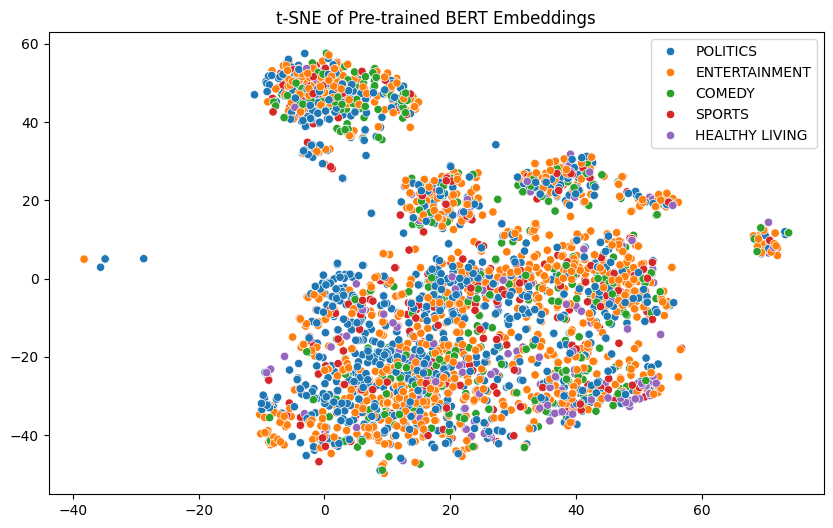

In [15]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot the result
plt.figure(figsize=(10, 6))
sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=categories, palette="tab10")
plt.title("t-SNE of Pre-trained BERT Embeddings")
plt.show()

# Preparing Data for Fine Tuning BERT Model

In [16]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

# Prepare labels
category_to_idx = {cat: idx for idx, cat in enumerate(set(categories))}
labels = [category_to_idx[cat] for cat in categories]

# Fine-tune BERT
model_fine_tuned = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(set(labels)))
model_fine_tuned.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [17]:
data = {
    "input_ids": inputs['input_ids'],
    "attention_mask": inputs['attention_mask'],
    "labels": labels
}

In [18]:
custom_dataset = Dataset.from_dict(data)
custom_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 5000
})

#Training the Model

In [19]:
# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=4,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
)

trainer = Trainer(
    model=model_fine_tuned,
    args=training_args,
    train_dataset=custom_dataset,  # Assuming inputs contain input_ids, attention_mask, and labels
)

In [20]:
# Fine-tune the model
trainer.train()

Step,Training Loss
500,1.458300
1000,1.373500
1500,1.286000
2000,1.246200
2500,1.233300
3000,1.008500
3500,1.028400
4000,0.956900
4500,0.834100
5000,0.856100


TrainOutput(global_step=12500, training_loss=0.8327224487304687, metrics={'train_runtime': 1154.633, 'train_samples_per_second': 43.304, 'train_steps_per_second': 10.826, 'total_flos': 642378277500000.0, 'train_loss': 0.8327224487304687, 'epoch': 10.0})

# Generating Embeddings from Fine Tuned Model

In [21]:
inputs = inputs.to(device)
with torch.no_grad():
    outputs = trainer.model.bert(**inputs)
    fine_tuned_embeddings = outputs.last_hidden_state[:, 0, :]  # CLS token embeddings

In [22]:
fine_tuned_embeddings = fine_tuned_embeddings.cpu()

### TSNE plot for embeddings generated from Fine Tuned Model

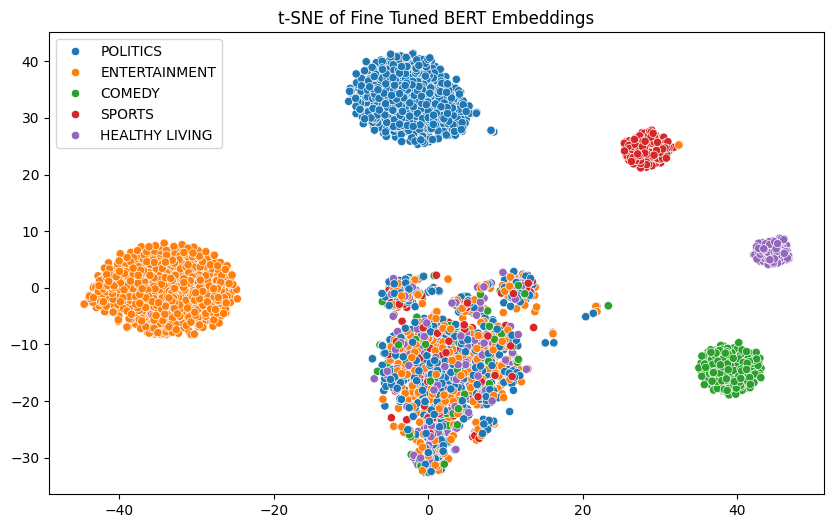

In [23]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(fine_tuned_embeddings)

# Plot the result
plt.figure(figsize=(10, 6))
sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=categories, palette="tab10")
plt.title("t-SNE of Fine Tuned BERT Embeddings")
plt.show()

### Save and Download the fine tuned model

In [24]:
# save model
trainer.save_model(output_dir=training_args.output_dir+"/model")
print("Model saved to:", training_args.output_dir+"/model")

Model saved to: ./results/model


In [25]:
! zip -r bert_news_ft.zip ./results/model

  adding: results/model/ (stored 0%)
  adding: results/model/model.safetensors (deflated 7%)
  adding: results/model/training_args.bin (deflated 51%)
  adding: results/model/config.json (deflated 53%)


In [26]:
from google.colab import files

files.download('bert_news_ft.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>